In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Download and Clean Data

In [0]:
(train_data, validation_data), info = tfds.load(
    'plant_village',
    with_info=True,
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]']
)

In [3]:
num_training_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
class_names = np.array(info.features['label'].names)

print("Number of training examples: ", num_training_examples)
print("Number of classes: ", num_classes)
print(class_names)

Number of training examples:  54303
Number of classes:  38
['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy' 'Cherry___healthy'
 'Cherry___Powdery_mildew' 'Corn___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn___Common_rust' 'Corn___healthy' 'Corn___Northern_Leaf_Blight'
 'Grape___Black_rot' 'Grape___Esca_(Black_Measles)' 'Grape___healthy'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___healthy'
 'Potato___Late_blight' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___healthy'
 'Strawberry___Leaf_scorch' 'Tomato___Bacterial_spot'
 'Tomato___Early_blight' 'Tomato___healthy' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tom

In [4]:
# check if the images have the same size
for i, image in enumerate(train_data.take(5)):
    print(f"Image{i+1} size: {image[0].shape}, Label: {image[1]}")

Image1 size: (256, 256, 3), Label: 35
Image2 size: (256, 256, 3), Label: 15
Image3 size: (256, 256, 3), Label: 31
Image4 size: (256, 256, 3), Label: 20
Image5 size: (256, 256, 3), Label: 3


In [0]:
# a function to reformat the images to the sizes expected by MobileNet
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
    return image, label

IMAGE_RES = 224
BATCH_SIZE = 32

training_batches = train_data.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_data.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Build Model using Transfer Learning

In [6]:
# Creating the model using pretrained model, MobileNet v2

model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                   input_shape=[IMAGE_RES, IMAGE_RES, 3], trainable=False),
    layers.Dense(38)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 38)                48678     
Total params: 2,306,662
Trainable params: 48,678
Non-trainable params: 2,257,984
_________________________________________________________________


In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(training_batches,
                    epochs=6,
                    validation_data=validation_batches)

Epoch 1/6
1358/1358 [==============================] - 56s 41ms/step - loss: 0.3894 - accuracy: 0.8988 - val_loss: 0.1801 - val_accuracy: 0.9474
Epoch 2/6
1358/1358 [==============================] - 54s 40ms/step - loss: 0.1433 - accuracy: 0.9578 - val_loss: 0.1382 - val_accuracy: 0.9572
Epoch 3/6
1358/1358 [==============================] - 54s 40ms/step - loss: 0.1036 - accuracy: 0.9687 - val_loss: 0.1302 - val_accuracy: 0.9571
Epoch 4/6
1358/1358 [==============================] - 54s 40ms/step - loss: 0.0802 - accuracy: 0.9756 - val_loss: 0.1175 - val_accuracy: 0.9614
Epoch 5/6
1358/1358 [==============================] - 54s 40ms/step - loss: 0.0658 - accuracy: 0.9804 - val_loss: 0.1121 - val_accuracy: 0.9641
Epoch 6/6
1358/1358 [==============================] - 54s 40ms/step - loss: 0.0555 - accuracy: 0.9837 - val_loss: 0.1198 - val_accuracy: 0.9615


Text(0.5, 1.0, 'Training & Validation Accuracy')

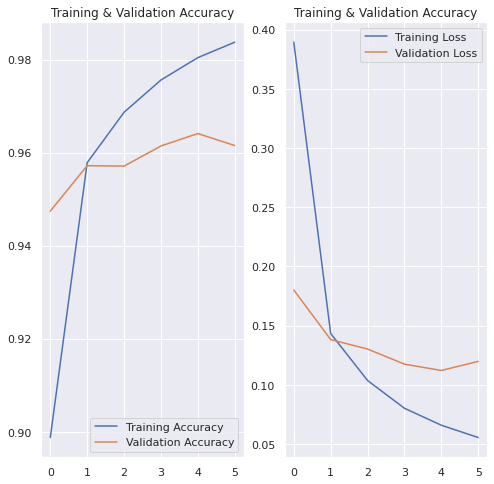

In [8]:
hist = pd.DataFrame(history.history)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(hist.accuracy, label='Training Accuracy')
plt.plot(hist.val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training & Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(hist.loss, label='Training Loss')
plt.plot(hist.val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training & Validation Accuracy")

## Make Predictions

In [9]:
image_batch, label_batch = next(iter(validation_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_ids = tf.squeeze(predicted_ids).numpy()

predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['Tomato___healthy',
       'Tomato___Spider_mites Two-spotted_spider_mite',
       'Tomato___Leaf_Mold', 'Orange___Haunglongbing_(Citrus_greening)',
       'Tomato___Late_blight', 'Strawberry___healthy',
       'Pepper,_bell___Bacterial_spot', 'Tomato___healthy',
       'Orange___Haunglongbing_(Citrus_greening)',
       'Potato___Early_blight',
       'Tomato___Spider_mites Two-spotted_spider_mite',
       'Apple___Black_rot', 'Squash___Powdery_mildew',
       'Orange___Haunglongbing_(Citrus_greening)', 'Apple___Black_rot',
       'Tomato___Target_Spot', 'Blueberry___healthy', 'Soybean___healthy',
       'Raspberry___healthy', 'Tomato___Late_blight',
       'Tomato___Leaf_Mold', 'Grape___healthy',
       'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Blueberry___healthy',
       'Squash___Powdery_mildew', 'Tomato___Bacterial_spot',
       'Tomato___Bacterial_spot', 'Grape___healthy', 'Corn___Common_rust',
       'Blueberry___healthy', 'Soybean___healthy', 'Corn___Common_rust'],
    

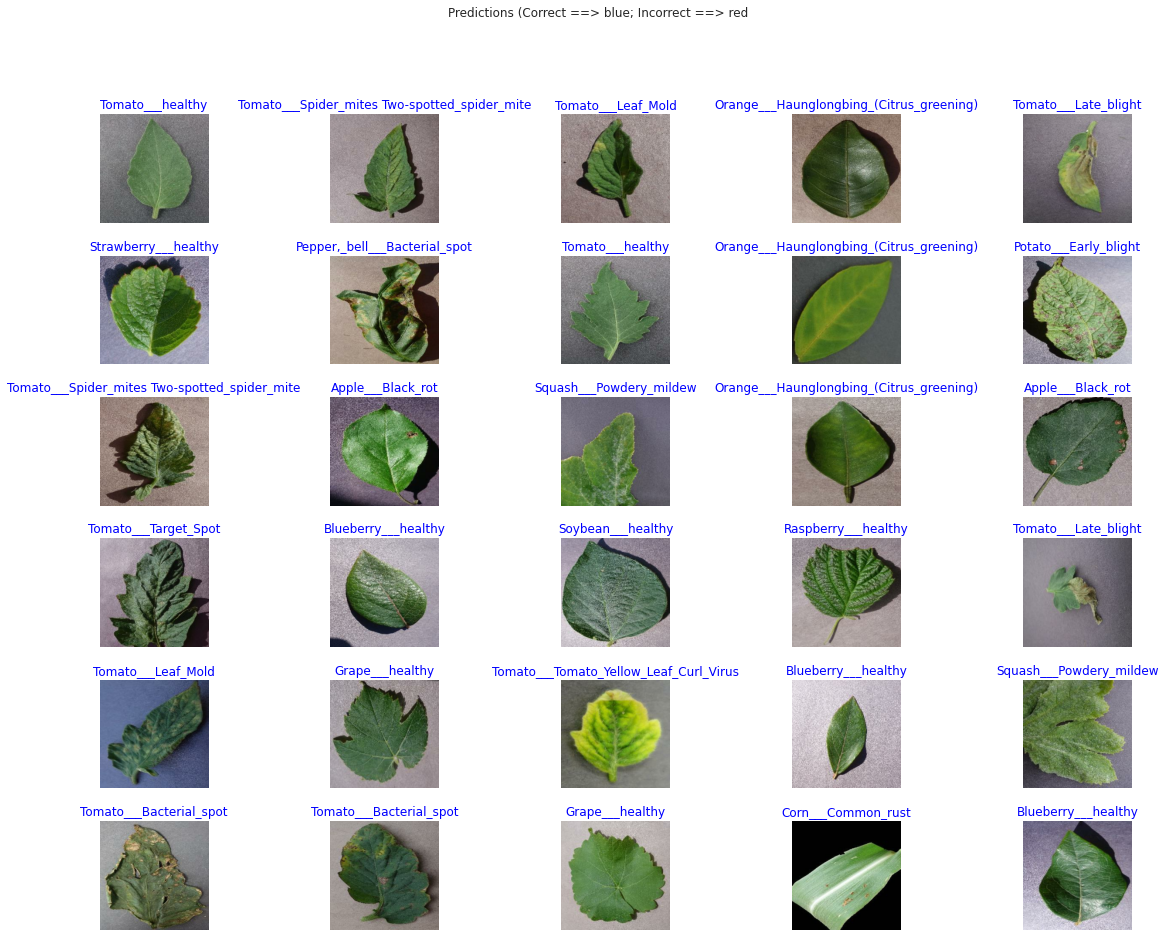

In [10]:
# Plot Model Predictions

plt.figure(figsize=(20, 15))
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(image_batch[n])
    plt.axis('off')
    color = 'blue' if predicted_ids[n] == label_batch[n] else 'red'
    plt.title(class_names[predicted_ids[n]], color=color)
_ = plt.suptitle("Predictions (Correct ==> blue; Incorrect ==> red")

## Save Model using SavedModel

In [11]:
t = time.time()

export_path = f"./PDD{int(t)}"
print(export_path)

tf.saved_model.save(model, export_path)

./PDD1588745587
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./PDD1588745587/assets


INFO:tensorflow:Assets written to: ./PDD1588745587/assets


In [12]:
!ls {export_path}

assets	saved_model.pb	variables


In [13]:
!zip -r model.zip {export_path}

  adding: PDD1588745587/ (stored 0%)
  adding: PDD1588745587/variables/ (stored 0%)
  adding: PDD1588745587/variables/variables.data-00000-of-00002 (deflated 88%)
  adding: PDD1588745587/variables/variables.index (deflated 79%)
  adding: PDD1588745587/variables/variables.data-00001-of-00002 (deflated 7%)
  adding: PDD1588745587/saved_model.pb (deflated 92%)
  adding: PDD1588745587/assets/ (stored 0%)


In [14]:
!ls

model.zip      PDD1588743777  PDD1588745030  sample_data
PDD1588742797  PDD1588744126  PDD1588745587


In [0]:
try:
    from google.colab import files
    files.download('./model.zip')
except ImportError:
    pass